# The Problem Statement:

The sequence identity of the COVID19 protease and that of SARS-CoV is high, hence by using the known SARS-CoV protease drugs generate possible drugs using machine learning methods to generate novel drug like candidates. Use a variational autoencoder with SMILES representation to generate novel molecules from the trained continuous latent space. The novel molecules shall be assessed based on SMART pattern matching, to rule out unlikely molecular structures e.g structures with multiple 3,4,7,8 membered rings, purely acyclic compounds, highly branched ones etc. Furthermore, diversity based on PubChem / MACCS fingerprints (tanimoto coefficients <= 0.60) shall also be assessed to make sure generated structures are significantly dissimilar to training set. Use multiple SARS-CoV-2 protease conformation to screen of generated chemicals using ensemble molecular docking protocol at both allosteric and orthosteric sites. Retain chemicals with best docking scores and binding energies as per the guidelines. Shortlist the top 100 or top 25% (max 100) hits and refine the best 10 using MD simulation without any restraints.

In [6]:
import pandas as pd
import numpy as np
import random

In [50]:
random.seed(24)

In [7]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem

def canonicalize(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

def validSMILES(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return True

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.cluster import KMeans

In [9]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
traindata = pd.read_csv('data/trainDILI.csv')

In [11]:
traindata['SMILES']

0                                        BrC(Cl)C(F)(F)F
1                            Br[C@@H](C(C)C)C(=O)NC(=O)N
2      Brc1[nH]c2c3c1CC1N(CC(C=C1c3ccc2)C(=O)N[C@]1(O...
3        Brc1c(nc(nc1Oc1c(cc(cc1C)C#N)C)Nc1ccc(cc1)C#N)N
4                             Brc1c2nccnc2ccc1NC=1NCCN=1
                             ...                        
961                           s1cccc1CN(CCN(C)C)c1ncccc1
962    s1cccc1C\C(=C/c1n(Cc2ccc(cc2)C(O)=O)c(nc1)CCCC...
963                               s1cccc1\C=C\C1=NCCCN1C
964          s1ccnc1NC(=O)C=1N(S(=O)(=O)c2c(cccc2)C=1O)C
965    s1cncc1COC(=O)NC(Cc1ccccc1)C(O)CC(NC(=O)C(NC(=...
Name: SMILES, Length: 966, dtype: object

In [12]:
traindata['cleanSMILES'] = traindata['SMILES'].apply(canonicalize)

In [13]:
traindata

,SMILES,Drug_Name,IsDILI,cleanSMILES
0,BrC(Cl)C(F)(F)F,Halothane,1.0,FC(F)(F)C(Cl)Br
1,Br[C@@H](C(C)C)C(=O)NC(=O)N,Bromisoval,1.0,CC(C)[C@H](Br)C(=O)NC(N)=O
2,Brc1[nH]c2c3c1CC1N(CC(C=C1c3ccc2)C(=O)N[C@]1(O...,Bromocriptine,0.0,CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=...
3,Brc1c(nc(nc1Oc1c(cc(cc1C)C#N)C)Nc1ccc(cc1)C#N)N,Etravirine,1.0,Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br
4,Brc1c2nccnc2ccc1NC=1NCCN=1,Brimonidine,0.0,Brc1c(NC2=NCCN2)ccc2nccnc12
...,...,...,...,...
961,s1cccc1CN(CCN(C)C)c1ncccc1,Methapyrilene,1.0,CN(C)CCN(Cc1cccs1)c1ccccn1
962,s1cccc1C\C(=C/c1n(Cc2ccc(cc2)C(O)=O)c(nc1)CCCC...,Eprosartan,0.0,CCCCc1ncc(/C=C(\Cc2cccs2)C(=O)O)n1Cc1ccc(C(=O)...
963,s1cccc1\C=C\C1=NCCCN1C,Pyrantel,0.0,CN1CCCN=C1/C=C/c1cccs1
964,s1ccnc1NC(=O)C=1N(S(=O)(=O)c2c(cccc2)C=1O)C,Sudoxicam,1.0,CN1C(C(=O)Nc2nccs2)=C(O)c2ccccc2S1(=O)=O


In [96]:
data = list(zip(traindata['SMILES'],traindata['cleanSMILES']))
identitydata = list(zip(traindata['cleanSMILES'],traindata['cleanSMILES']))

In [98]:
identitydata

[('FC(F)(F)C(Cl)Br', 'FC(F)(F)C(Cl)Br'),
 ('CC(C)[C@H](Br)C(=O)NC(N)=O', 'CC(C)[C@H](Br)C(=O)NC(N)=O'),
 ('CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12',
  'CC(C)CC1C(=O)N2CCCC2[C@@]2(O)O[C@@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12'),
 ('Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br',
  'Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc(N)c1Br'),
 ('Brc1c(NC2=NCCN2)ccc2nccnc12', 'Brc1c(NC2=NCCN2)ccc2nccnc12'),
 ('Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21',
  'Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21'),
 ('CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1',
  'CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1'),
 ('NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1',
  'NC(N)=Nc1nc(CSCC/N=C/NS(=O)(=O)c2ccc(Br)cc2)cs1'),
 ('Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1',
  'Nc1c(CC(=O)O)cccc1C(=O)c1ccc(Br)cc1'),
 ('CN(C)CCC(c1ccc(Br)cc1)c1ccccn1', 'CN(C)CCC(c1ccc(Br)cc1)c1ccccn1'),
 ('Brc1ccccc1', 'Brc1ccccc1'),
 ('CCCC1CC(C(=O)NC(C(C)Cl)C2OC(SC

We clean up the similes strings into stuff that can be fed into the LSTM
#use content from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [99]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def addSMILES(self, smiles):
        for char in smiles:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

max([len(smiles) for smiles in traindata['SMILES'] ]) = 297

max([len(smiles) for smiles in traindata['cleanSMILES'] ]) = 293

In [100]:
MAX_LENGTH = 300

In [101]:
def prepareData(lang1, lang2, data):
    """takes data as list of pairs for now
    returns the dictionaries for input and output languages, and the pairs"""
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = data
    print("Read %s smiles pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSMILES(pair[0])
        output_lang.addSMILES(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [102]:
#input_lang, output_lang, pairs = prepareData("Random SMILES","Canonical SMILES", data)
input_lang, output_lang, pairs = prepareData("Canonical SMILES","Canonical SMILES", identitydata)
print(random.choice(pairs))

Read 966 smiles pairs
Counting chars...
Counted chars:
Canonical SMILES 37
Canonical SMILES 37
('CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1', 'CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1')


In [103]:
input_lang

Now we implement the seq-to-vec part

In [104]:
class EncoderRNN(nn.Module):
    """what is
    input size - number of different characters that can be in a smiles string
    hidden size
    """
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        #first dim is batch size
        #second dim is seq len?? or other way around?
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [105]:
class DecoderRNN(nn.Module):
    """output size: number of chars in canonical smiles language"""
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [106]:
def indexesFromSmiles(lang, smiles):
    return [lang.char2index[char] for char in smiles]


def tensorFromSmiles(lang, smiles):
    indexes = indexesFromSmiles(lang, smiles)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSmiles(input_lang, pair[0])
    target_tensor = tensorFromSmiles(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [107]:
indexesFromSmiles(input_lang, 'CCCO')

[3, 3, 3, 14]

In [108]:
tensorsFromPair(pairs[0])

(tensor([[2],
         [3],
         [4],
         [2],
         [5],
         [4],
         [2],
         [5],
         [3],
         [4],
         [3],
         [6],
         [5],
         [7],
         [8],
         [1]]),
 tensor([[2],
         [3],
         [4],
         [2],
         [5],
         [4],
         [2],
         [5],
         [3],
         [4],
         [3],
         [6],
         [5],
         [7],
         [8],
         [1]]))

In [109]:
output_lang.char2index

{'F': 2,
 'C': 3,
 '(': 4,
 ')': 5,
 'l': 6,
 'B': 7,
 'r': 8,
 '[': 9,
 '@': 10,
 'H': 11,
 ']': 12,
 '=': 13,
 'O': 14,
 'N': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 'c': 20,
 '5': 21,
 '6': 22,
 'n': 23,
 '#': 24,
 'o': 25,
 'S': 26,
 '/': 27,
 's': 28,
 'P': 29,
 '+': 30,
 '-': 31,
 '\\': 32,
 'I': 33,
 '7': 34,
 '8': 35,
 '9': 36}

In [110]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,\
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """This trains on a single smiles string"""
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            """What is history? why not use topi.item?"""
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [111]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [123]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=50, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [125]:
def evaluate(encoder, decoder, smiles, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSmiles(input_lang, smiles)
        #print("\nInput tensor shape: ", input_tensor.shape)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        #print("\nencoder hidden shape: ", encoder_hidden.shape)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        #print("\nencoder outputs shape: ", encoder_outputs.shape)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_chars = []
        #decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #decoder_output, decoder_hidden, decoder_attention = decoder(\
            #decoder_input, decoder_hidden, encoder_outputs)
            #we dont care about encoder outputs, lets see what happens
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #decoder_attentions[di] = decoder_attention.data
            #print("decoder output shape: ",decoder_output.shape)
            #print("decoder output: ",decoder_output)
            topv, topi = decoder_output.data.topk(1)
            #print("topv: ",topv) 
            """topv is the largest component of decoder output (which is a softmax) over the 37 
            characters in can smiles lang, topi is its index"""
            #print("topi: ",topi)
            if topi.item() == EOS_token:
                decoded_chars.append('<EOS>')
                break
            else:
                decoded_chars.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return ''.join(decoded_chars)

In [126]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('original smiles', pair[0])
        print('actual canonical SMILES', pair[1])
        output_smiles = evaluate(encoder, decoder, pair[0])
        print('predicted canonical SMILES', output_smiles)
        print('')

# Actual training

## Loading a saved model

In [130]:
hidden_size = 256

from pathlib import Path
savedencoderfile = "SMILESencoder.pt"
saveddecoderfile = "SMILESdecoder.pt"
if Path(savedencoderfile).is_file():
    # file exists
    encoder1.load_state_dict(torch.load(savedencoderfile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedencoderfile)
else:
    encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
    
    
if Path(saveddecoderfile).is_file():
    # file exists
    decoder1.load_state_dict(torch.load(saveddecoderfile))
    #model.eval() wtf is this
    print("=== Decoder was loaded from " + saveddecoderfile)
else:
    decoder1 = DecoderRNN(hidden_size, output_lang.n_chars).to(device)

In [128]:
evaluate(encoder1, decoder1, 'CCCOC')

'------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

0m 10s (- 0m 20s) (50 33%) 12.4331
0m 19s (- 0m 9s) (100 66%) 12.1467
0m 31s (- 0m 0s) (150 100%) 18.7371


<Figure size 432x288 with 0 Axes>

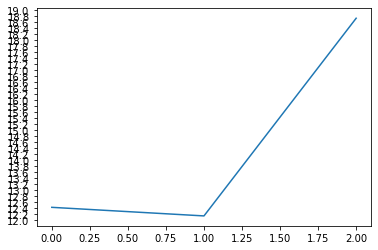

In [129]:
trainIters(encoder1, decoder1, 150, print_every=50)

In [95]:
evaluateRandomly(encoder1, decoder1)

original smiles OC(=O)C(N)Cc1c2c([nH]c1)cccc2
actual canonical SMILES NC(Cc1c[nH]c2ccccc12)C(=O)O
predicted canonical SMILES [)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)1)

original smiles O=C(N)c1nc[nH]c1N=NN(C)C
actual canonical SMILES CN(C)N=Nc1[nH]cnc1C(N)=O
predicted canonical SMILES [)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)

original smiles OC(=O)Cc1ccc(cc1)CC(C)C
actual canonical SMILES CC(C)Cc1ccc(CC(=O)O)cc1
predicted canonical SMILES [)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[)[

# Saving the model

In [132]:
torch.save(encoder1.state_dict(), savedencoderfile)
torch.save(decoder1.state_dict(), saveddecoderfile)
print("Model was saved as ",savedencoderfile, "and", savedencoderfile )

Model was saved as  SMILESencoder.pt and SMILESencoder.pt


In [ ]:

#################################
class Model_RNN(nn.Module):
    def __init__(self):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(
                input_size = input_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True)
        self.Rnn_type = 'RNN'

    def forward(self, x, hidden):
        # Reshape input in (bs, seqlen, inpsz)
        x = x.view(batch_size, seq_len, input_size)

        # Propagete inp thru RNN
        #   Input: (batchsz, seq_len, inpsz)
        out, hidden = self.rnn(x, hidden)

        # Output: (batchsz, seq_len, hiddensz)
        out = out.view(-1, num_classes)
        return hidden, out

    def init_hidden(self):
        # Init hidden and cell states
        # (num_layers * num_dir, batch, hidden_sz)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))

class Model_LSTM(nn.Module):
    def __init__(self):
        super(Model_LSTM, self).__init__()
        self.rnn = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first = True)
        self.Rnn_type = 'LSTM'

    def forward(self, x, hidden):
        # Reshape input in (bs, seqlen, inpsz)
        x = x.view(batch_size, seq_len, input_size)

        # Propagete inp thru RNN
        #   Input: (batchsz, seq_len, inpsz)
        out, hidden = self.rnn(x, hidden)

        # Output: (batchsz, seq_len, hiddensz)
        out = out.view(-1, num_classes)
        return hidden, out

    def init_hidden(self):
        # Init hidden and cell states
        # (num_layers * num_dir, batch, hidden_sz)
        # LSTM hidden state is a tuple (h_0, c_0)
        h_0 = Variable(torch.zeros(num_layers, batch_size, hidden_size))
        c_0 = Variable(torch.zeros(num_layers, batch_size, hidden_size))
        hidden = (h_0, c_0)
        return hidden

#################################

Inp_size = len(Inp_alphabet)
Out_size = len(Out_alphabet)
torch.manual_seed(2.7321)

#################################
num_classes = Out_size          #  XXX why need a separate num_classes,  when hidden_size would do?
input_size = Inp_size  # this parameter is for the view function to know how large
#the one hot vector is supposed to be

hidden_size = Out_size #
batch_size = 1   # id dont understand this
seq_len = Seq_max
num_layers = Arg_num_layers  # num-layers of rnn
#learning_rate = 0.01
momentum = 0.1


############## Model Training code ##########################
def train_phase():
    global Optimizer
    MIN_LOSS = float('inf')
    MIN_LOSS_epoch_counter = 0
    MAX_ACC_epoch_counter = 0

    final_train_epoch=0
    final_train_accuracy=0

    for epoch in range(max_epochs):
        Optimizer.zero_grad()
        loss = 0
        errcount = 0
        # if epoch % 30 ==0:
        #     evaluate_model(inputs,labels)
        for input, label in zip(Inputs, Labels):
            # input = input.unsqueeze(0)
            hidden = model.init_hidden() #we reset the RNN to its initial state
            hidden, output = model(input, hidden) #run the model

            val, idx = output.max(1)
            expected = decode_out(label)
            trained = decode_out(idx)

            if trained != expected:
                errcount += 1

            if epoch % vizdelay == 0:
                if (trained != expected):
                    print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", trained, "   *****")
                else:
                    print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", trained)
            loss += Criterion(output, label) #add the current sample error to loss

        loss.backward()
        Optimizer.step()

        ########### Within loop plotting and logging ########
        if loss.data < MIN_LOSS:
            MIN_LOSS = loss.data
            MIN_LOSS_epoch_counter = epoch   # reset

        accuracy = 100.0 * (Num_io_data - errcount) / Num_io_data
        print("Epoch: %d, loss: %1.3f         errcount: %d  accuracy: %1.1f%%\n" % (epoch+1, loss.data, errcount, accuracy))
        print("-------------------------------------------")

        plot_data.append([loss.data.item(), accuracy])
        t = [ x for x in range(0, epoch)]
        p = np.array(plot_data)
        plt_ax1.plot(p[:, 0], color='red')
        plt_ax2.plot(p[:, 1], color='blue')
        plt.pause(0.001)
        #plt.show()

        final_train_epoch = epoch
        final_train_accuracy = accuracy
        if BREAK_EARLY == True:
            global Train_end_reason
            if (epoch - MIN_LOSS_epoch_counter) >= 20:
                Train_end_reason = "=== no new low of training_loss seen for last 20 epochs; stop training"
                print(Train_end_reason)
                break

            if accuracy >= 99.9:
                MAX_ACC_epoch_counter += 1
                # stop, if accuracy stays at ~100 for 10 epochs
                if MAX_ACC_epoch_counter >= 10:
                    Train_end_reason = "=== maximal accuracy seen for last 10 epochs; stop training"
                    print(Train_end_reason)
                    time.sleep(4)
                    break

        # update optimizer with changed lr - depending on accuracy
        Optimizer = get_new_optimizer(learning_rate, accuracy)
    return final_train_accuracy, final_train_epoch


####################### Model evaluation code ################
def evaluate_model_1(xdata, ydata):
    x_one_hot = simple_to_onehot(xdata, Inp_alphabet)
    inputs = Variable(torch.Tensor(x_one_hot))
    labels = Variable(torch.LongTensor(ydata))

    err_count = 0
    for input, label in zip(inputs, labels):
        expected = decode_out(label)
        hidden = model.init_hidden()
        hidden, output = model(input, hidden)
        val, idx = output.max(1)
        predicted = decode_out(idx)
        if (expected != predicted):
            print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", predicted, "   *****")
            err_count += 1
        else:
            print("check : ", decode_inp(input), " -> expected: ", expected, "        predicted: ", predicted)
    return (err_count)

def evaluate_model(xdata, ydata, seqmax):
    xdata = simple_encode_strlist(xdata, seqmax, Inp_alphabet)
    ydata = simple_encode_strlist(ydata, seqmax, Out_alphabet)
    return evaluate_model_1(xdata, ydata)

################################################################################
def validation_phase():
    print("============================= validation inputs ===========================")
    validation_inputs, validation_outputs, seqmax = load_data_file('rnn3-train-data.txt')
    num_io_data = len(validation_inputs)
    if seqmax != Seq_max:
        print("seqmax mismatch", seqmax, Seq_max)
        sys.exit(1)
    seqmax = Seq_max

    errcount = evaluate_model(validation_inputs, validation_outputs, seqmax)
    val_accuracy = 100.0 * (num_io_data - errcount) / num_io_data

    if errcount > 0:
        print("VALIDATION FAILED:  errors: ", errcount, "accuracy:", val_accuracy)
    else:
        print("Validation Passed")
    return val_accuracy


################################################################################
def test_phase():
    print("============================= test inputs ===========================")
    test_inputs, test_outputs, seqmax = load_data_file('rnn3-test-data.txt')
    num_io_data = len(test_inputs)
    #if seqmax != Seq_max: #this could happen just due to randomness #todo
    #    print("WARN: seqmax mismatch")     ## possible to have diff seq max from the train data
    #    sys.exit(1)
    seqmax = Seq_max


    errcount = evaluate_model(test_inputs, test_outputs, seqmax)
    test_accuracy = 100.0 * (num_io_data - errcount) / num_io_data

    print("Testset size: ", len(test_inputs),"Test errors: ", errcount, "accuracy:", test_accuracy)
    return test_accuracy

################################################################################

########################################################
#Instantiate RNN model
#model = Model_RNN()
Rnn_type = '###'
model = Model_LSTM()
Rnn_type = model.Rnn_type

####################### Plotting code ##################

plt.ion()
plt_fig, plt_ax1 = plt.subplots()
plt_ax2 = plt_ax1.twinx()
plt_ax1.set_xlabel('epoch')
plt_ax1.set_ylabel('loss', color='red')
plt_ax2.set_ylabel('accuracy', color='blue')

txt = "Dataset: " + Arg_dataset_name + "\nrnn_type: "+ Rnn_type + "\nnum_layers: "+ str(num_layers) + "\nnum_io_samples: "+ str(Num_io_data) + "\nseq_max_len: "+ str(Seq_max)
txt += "\nBase_LR: " + str(learning_rate)

#plt_fig = plt.figure()
plt_fig.text(.5, .2, txt, ha='center', transform=plt_ax1.transAxes)
plt.pause(0.001)

plot_data = []
########################################################



################## Load trained model ###############
from pathlib import Path
modelimagefile = "rnn3model." + Imagesuffix + ".pt"
if Path(modelimagefile).is_file():
    # file exists
    model.load_state_dict(torch.load(modelimagefile))
    model.eval()
    print("=== Model was loaded from " + modelimagefile)

####################################################
Criterion = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
####################################################



# X is OH encoded
# Y is simple encoded
# this is the format needed by pytorch
Inputs = Variable(torch.Tensor(X_ohe))
Labels = Variable(torch.LongTensor(Y_data))

print("Input shape: ", Inputs.size())
print("Output shape: ", Labels.size())

final_train_accuracy, final_train_epoch = train_phase()

############ final plotting and logging ################
#plt.plot(plot_data)
#plt.waitforbuttonpress()
plt.savefig('rnn3-ttt.png',  bbox_inches='tight')
plt.show()
########################################################

val_accuracy = validation_phase()
test_accuracy = test_phase()

print("---------------------------------------------------------------------")
print("=== rnn_type:", Rnn_type,
        "num_layers:", num_layers,
        "num_io_samples (train): ", Num_io_data,
        "seq_max_len:", Seq_max)

print("\n Training end due to: ", Train_end_reason)
print("\n=== final_train_epoch:", final_train_epoch)
print("=== final_train_accuracy:  %1.2f%%       \n=== val_accuracy:  %1.2f%%        \n=== test_accuracy:  %1.2f%%\n"
        %  (final_train_accuracy, val_accuracy, test_accuracy))


######################### save trained model #######################
torch.save(model.state_dict(), modelimagefile)
print("=== Model was saved as " + modelimagefile)
####################################################################

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
print("Train proportion: ",len(Xtrain)/len(X))

Train proportion:  0.7494824016563147


In [37]:
skmodel = LogisticRegression(class_weight='balanced')
#skmodel = LogisticRegression()
#skmodel = GaussianNB()
skmodel.fit(Xtrain, ytrain)                  
y_model = skmodel.predict(Xtest)   
ytrain_model = skmodel.predict(Xtrain)
print('Train accuracy: ',accuracy_score(ytrain, ytrain_model))
print('Test accuracy: ',accuracy_score(ytest, y_model))
print('F1 score: ',f1_score(ytest, y_model))
print('Matthews correlation coefficient: ',matthews_corrcoef(ytest,y_model))

Train accuracy:  0.9378453038674033
Test accuracy:  0.6074380165289256
F1 score:  0.6215139442231075
Matthews correlation coefficient:  0.21430796208172556


Basic Logistic regression
Train accuracy:  0.9972375690607734
Test accuracy:  0.5867768595041323
F1 score:  0.5934959349593496
Matthews correlation coefficient:  0.17332786773245884

In [38]:
Xtrain.shape

(724, 512)

In [44]:
input_size = 512
output_size = 1
hidden_sizes = [128, 64]
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Sigmoid())
print(model)
criterion = nn.MSELoss()

#CrossEntropyLoss() requires logits as the output and class labels as the target

Sequential(
  (0): Linear(in_features=512, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


In [48]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
print("Xtrain.shape: ",Xtrain.shape)

Xtrain.shape:  torch.Size([724, 512])


In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #weight_decay=1e-5
epochs = 10
for e in range(epochs):
    output = model(Xtrain)
    labels = ytrain.unsqueeze(1)
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    if e % 2 == 0:
        print("Training loss: ",loss.item())

Training loss:  0.0852215439081192
Training loss:  0.07720500975847244
Training loss:  0.08967221528291702
Training loss:  0.10272926092147827
Training loss:  0.07113324850797653


In [57]:
predictions = output.detach().numpy()
predictions = np.where(predictions > 0.5, 1, 0)
predictions.sum()

354

In [58]:
testoutput = model(Xtest)
testpredictions = testoutput.detach().numpy()
testpredictions = np.where(testpredictions > 0.5, 1, 0)
testpredictions.sum()

100

In [59]:
print('Train accuracy: ',accuracy_score(predictions,ytrain))
print('Test accuracy: ',accuracy_score(testpredictions, ytest))
print('F1 score: ',f1_score(testpredictions, ytest))
print('Matthews: ',matthews_corrcoef(testpredictions, ytest))

Train accuracy:  0.9406077348066298
Test accuracy:  0.5661157024793388
F1 score:  0.5291479820627804
Matthews:  0.13720062149495627


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

In [2]:
print("hello")

hello
